In [70]:
from convpers import CPT
from convpers import Vectorize
from convpers import Testing
from convpers import Filters
from convpers import Data
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#To get the data: https://www.kaggle.com/code/rkuo2000/chinese-mnist

In [71]:
X_orig,y = Data.load_chinese("C:/Users/Elchanan/Desktop/Work/convperstran/data/","C:/Users/Elchanan/Desktop/Work/convperstran/data/")

In [72]:
idxs = [int(i) for i in np.random.choice(range(len(X_orig)),3000)]
X_orig = X_orig[idxs]
y = y[idxs]

In [73]:
#downsample images
from skimage.measure import block_reduce
X = []
for x in X_orig:
    X.append(block_reduce(x,(2,2),np.max))

Text(0.5, 0.98, 'Chinese Digit Examples')

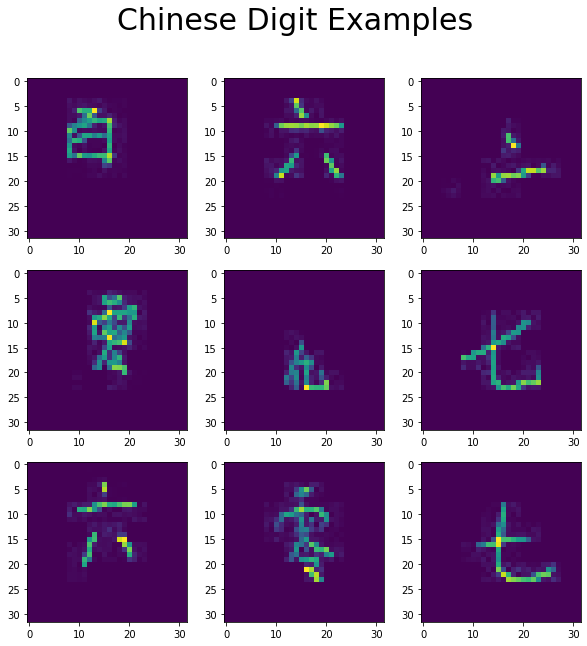

In [77]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,3)
fig.set_size_inches(10,10)
axs[0,0].imshow(X[0])
axs[0,1].imshow(X[1])
axs[0,2].imshow(X[2])
axs[1,0].imshow(X[3])
axs[1,1].imshow(X[4])
axs[1,2].imshow(X[5])
axs[2,0].imshow(X[6])
axs[2,1].imshow(X[7])
axs[2,2].imshow(X[8])
fig.suptitle("Chinese Digit Examples",fontsize=30)

kNN Results:  [0.367 0.332 0.33 ]
Average kNN Result:  0.343
Gradient Boosting Results:  [0.52  0.538 0.474]
Average Gradient Boosting Result:  0.5106666666666667


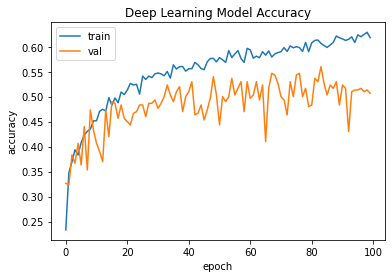

Final Validation Accuracy:  0.5066666603088379


In [50]:
#Experiment 1A: No Convolutions, Persistence Images Concatenated
filter = Filters.blur_kernel(1)
diagrams = CPT.CPT(X,[filter])
pers_images = Vectorize.diagrams_to_images(diagrams)
pers_image_con = Vectorize.concatenate_top_features(pers_images)
Testing.test_knn(pers_image_con,y)
Testing.test_boosted_tree(pers_image_con,y)
Testing.test_NN(pers_image_con,y)

kNN Results:  [0.367 0.332 0.33 ]
Average kNN Result:  0.343
Gradient Boosting Results:  [0.52  0.538 0.474]
Average Gradient Boosting Result:  0.5106666666666667


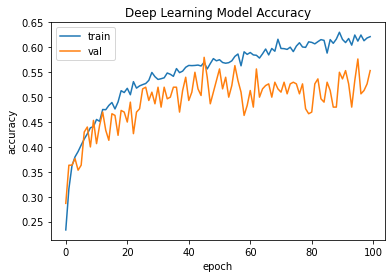

Final Validation Accuracy:  0.5533333420753479


In [51]:
#Experiment 1B: No Convolutions, Persistence Images Averaged
pers_image_av = Vectorize.average_top_features(pers_images)
Testing.test_knn(pers_image_av,y)
Testing.test_boosted_tree(pers_image_av,y)
Testing.test_NN(pers_image_av,y)

kNN Results:  [0.24  0.241 0.255]
Average kNN Result:  0.24533333333333332
Gradient Boosting Results:  [0.29  0.293 0.292]
Average Gradient Boosting Result:  0.2916666666666667


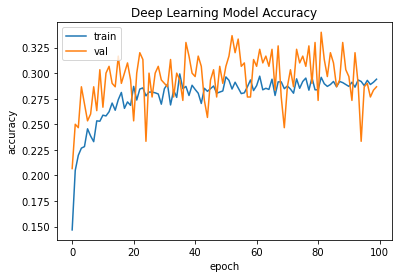

Final Validation Accuracy:  0.2866666615009308


In [52]:
#Experiment 1C: No Convolutions, Total Persistence Concatenated
tot_pers = Vectorize.diagrams_to_totpers(diagrams)
tot_pers_con = Vectorize.concatenate_top_features(tot_pers)
Testing.test_knn(tot_pers_con,y)
Testing.test_boosted_tree(tot_pers_con,y)
Testing.test_NN(tot_pers_con,y)

kNN Results:  [0.24  0.241 0.255]
Average kNN Result:  0.24533333333333332
Gradient Boosting Results:  [0.29  0.293 0.292]
Average Gradient Boosting Result:  0.2916666666666667


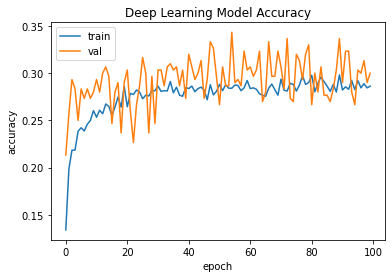

Final Validation Accuracy:  0.30000001192092896


In [53]:
#Experiment 1D: No Convolutions, Total Persistence Averaged
tot_pers_av = Vectorize.average_top_features(tot_pers)
Testing.test_knn(tot_pers_av,y)
Testing.test_boosted_tree(tot_pers_av,y)
Testing.test_NN(tot_pers_av,y)

kNN Results:  [0.437 0.441 0.424]
Average kNN Result:  0.434
Gradient Boosting Results:  [0.592 0.613 0.589]
Average Gradient Boosting Result:  0.598


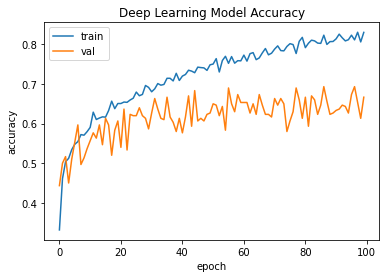

Final Validation Accuracy:  0.6666666865348816


In [54]:
#Experiment 2A: Adding Convolutions with Standard Filters, Persistence Images Concatenated
filter1 = Filters.blur_kernel(1)
filter2 = Filters.blur_kernel(3)
filter3 = Filters.gaussian_kernel(3)
filter4 = Filters.sharpening_kernel(3)
diagrams = CPT.CPT(X,[filter1,filter2,filter3,filter4])
pers_images = Vectorize.diagrams_to_images(diagrams)
pers_image_con = Vectorize.concatenate_top_features(pers_images)
Testing.test_knn(pers_image_con,y)
Testing.test_boosted_tree(pers_image_con,y)
Testing.test_NN(pers_image_con,y)

kNN Results:  [0.394 0.405 0.396]
Average kNN Result:  0.3983333333333334
Gradient Boosting Results:  [0.496 0.516 0.51 ]
Average Gradient Boosting Result:  0.5073333333333333


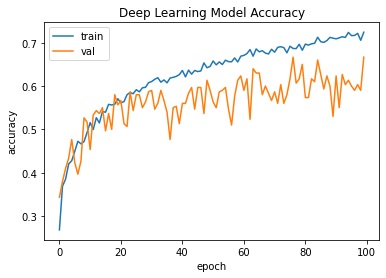

Final Validation Accuracy:  0.6666666865348816


In [55]:
#Experiment 2B: Adding Convolutions with Standard Filters, Persistence Images Averaged
pers_image_av = Vectorize.average_top_features(pers_images)
Testing.test_knn(pers_image_av,y)
Testing.test_boosted_tree(pers_image_av,y)
Testing.test_NN(pers_image_av,y)

kNN Results:  [0.226 0.234 0.235]
Average kNN Result:  0.2316666666666667
Gradient Boosting Results:  [0.43  0.419 0.42 ]
Average Gradient Boosting Result:  0.423


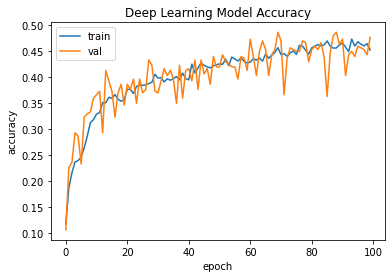

Final Validation Accuracy:  0.476666659116745


In [56]:
#Experiment 2C: Adding Convolutions with Standard Filters, Total Persistence Concatenated
tot_pers = Vectorize.diagrams_to_totpers(diagrams)
tot_pers_con = Vectorize.concatenate_top_features(tot_pers)
Testing.test_knn(tot_pers_con,y)
Testing.test_boosted_tree(tot_pers_con,y)
Testing.test_NN(tot_pers_con,y)

kNN Results:  [0.222 0.223 0.238]
Average kNN Result:  0.22766666666666668
Gradient Boosting Results:  [0.241 0.236 0.24 ]
Average Gradient Boosting Result:  0.239


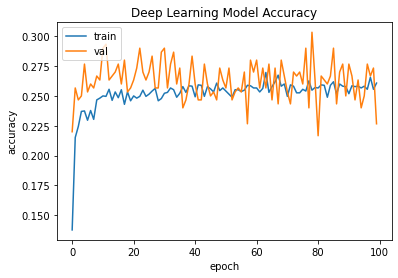

Final Validation Accuracy:  0.2266666740179062


In [57]:
#Experiment 2D: Adding Convolutions with Standard Filters, Total Persistence Averaged
tot_pers_av = Vectorize.average_top_features(tot_pers)
Testing.test_knn(tot_pers_av,y)
Testing.test_boosted_tree(tot_pers_av,y)
Testing.test_NN(tot_pers_av,y)

kNN Results:  [0.547 0.58  0.571]
Average kNN Result:  0.566
Gradient Boosting Results:  [0.733 0.737 0.698]
Average Gradient Boosting Result:  0.7226666666666667


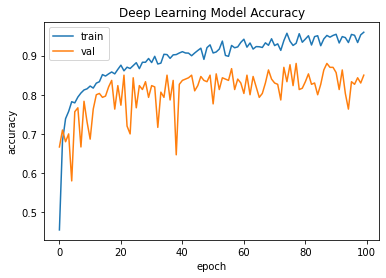

Final Validation Accuracy:  0.8500000238418579


In [58]:
#Experiment 3A: Adding Convolutions with EigenFilters, Persistence Images Concatenated
eigen_filters = Filters.PCA_eigenfilters(X,l=3,n=3)
filters = Filters.random_linear_comb(eigen_filters,5)
diagrams = CPT.CPT(X,filters)
pers_images = Vectorize.diagrams_to_images(diagrams)
pers_image_con = Vectorize.concatenate_top_features(pers_images)
Testing.test_knn(pers_image_con,y)
Testing.test_boosted_tree(pers_image_con,y)
Testing.test_NN(pers_image_con,y)

kNN Results:  [0.512 0.521 0.49 ]
Average kNN Result:  0.5076666666666666
Gradient Boosting Results:  [0.617 0.64  0.611]
Average Gradient Boosting Result:  0.6226666666666667


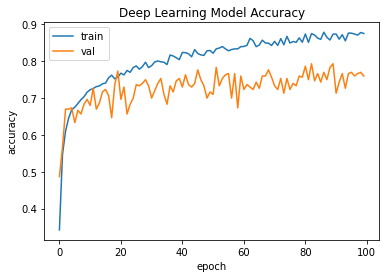

Final Validation Accuracy:  0.7599999904632568


In [59]:
#Experiment 3B: Adding Convolutions with EigenFilters, Persistence Images Averaged
pers_image_av = Vectorize.average_top_features(pers_images)
Testing.test_knn(pers_image_av,y)
Testing.test_boosted_tree(pers_image_av,y)
Testing.test_NN(pers_image_av,y)

kNN Results:  [0.561 0.573 0.518]
Average kNN Result:  0.5506666666666666
Gradient Boosting Results:  [0.528 0.539 0.535]
Average Gradient Boosting Result:  0.5340000000000001


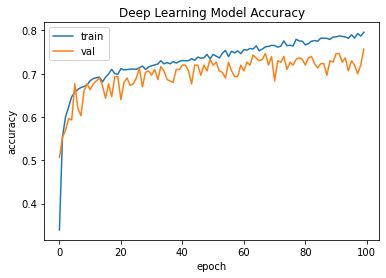

Final Validation Accuracy:  0.7566666603088379


In [60]:
#Experiment 3C: Adding Convolutions with EigenFilters, Total Persistence Concatenated
tot_pers = Vectorize.diagrams_to_totpers(diagrams)
tot_pers_con = Vectorize.concatenate_top_features(tot_pers)
Testing.test_knn(tot_pers_con,y)
Testing.test_boosted_tree(tot_pers_con,y)
Testing.test_NN(tot_pers_con,y)

kNN Results:  [0.27  0.258 0.258]
Average kNN Result:  0.262
Gradient Boosting Results:  [0.276 0.306 0.271]
Average Gradient Boosting Result:  0.2843333333333334


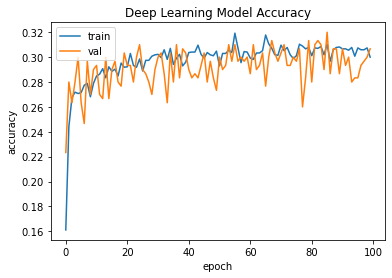

Final Validation Accuracy:  0.30666667222976685


In [61]:
#Experiment 3D: Adding Convolutions with EigenFilters, Total Persistence Averaged
tot_pers_av = Vectorize.average_top_features(tot_pers)
Testing.test_knn(tot_pers_av,y)
Testing.test_boosted_tree(tot_pers_av,y)
Testing.test_NN(tot_pers_av,y)

kNN Results:  [0.521 0.533 0.539]
Average kNN Result:  0.531
Gradient Boosting Results:  [0.673 0.658 0.673]
Average Gradient Boosting Result:  0.668


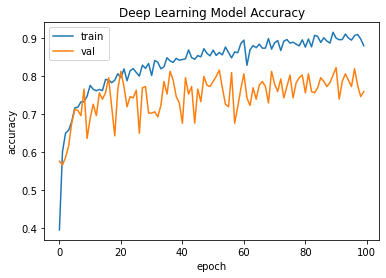

Final Validation Accuracy:  0.7599999904632568


In [62]:
#Experiment 4A: Random Filters, Persistence Images Concatenated
random_filters = Filters.random_filters(l=3,n=5)
diagrams = CPT.CPT(X,random_filters)
pers_images = Vectorize.diagrams_to_images(diagrams)
pers_image_con = Vectorize.concatenate_top_features(pers_images)
Testing.test_knn(pers_image_con,y)
Testing.test_boosted_tree(pers_image_con,y)
Testing.test_NN(pers_image_con,y)

kNN Results:  [0.472 0.494 0.45 ]
Average kNN Result:  0.472
Gradient Boosting Results:  [0.578 0.589 0.583]
Average Gradient Boosting Result:  0.5833333333333333


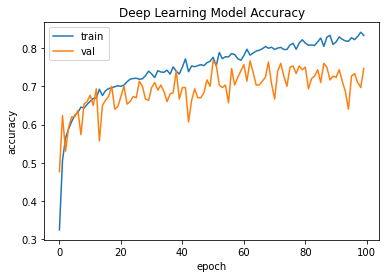

Final Validation Accuracy:  0.746666669845581


In [63]:
#Experiment 4B: Random Filters, Persistence Images Averaged
pers_image_av = Vectorize.average_top_features(pers_images)
Testing.test_knn(pers_image_av,y)
Testing.test_boosted_tree(pers_image_av,y)
Testing.test_NN(pers_image_av,y)

kNN Results:  [0.483 0.493 0.486]
Average kNN Result:  0.48733333333333334
Gradient Boosting Results:  [0.509 0.535 0.515]
Average Gradient Boosting Result:  0.5196666666666667


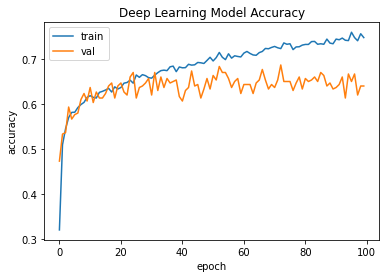

Final Validation Accuracy:  0.6399999856948853


In [64]:
#Experiment 4C: Random Filters, Total Persistence Concatenated
tot_pers = Vectorize.diagrams_to_totpers(diagrams)
tot_pers_con = Vectorize.concatenate_top_features(tot_pers)
Testing.test_knn(tot_pers_con,y)
Testing.test_boosted_tree(tot_pers_con,y)
Testing.test_NN(tot_pers_con,y)

kNN Results:  [0.274 0.259 0.252]
Average kNN Result:  0.26166666666666666
Gradient Boosting Results:  [0.287 0.285 0.288]
Average Gradient Boosting Result:  0.2866666666666666


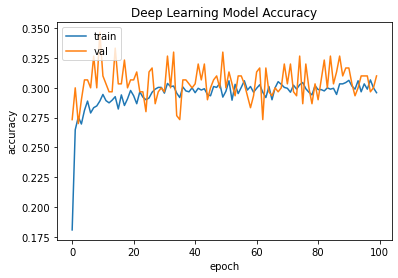

Final Validation Accuracy:  0.3100000023841858


In [65]:
#Experiment 4D: Random Filters, Total Persistence Averaged
tot_pers_av = Vectorize.average_top_features(tot_pers)
Testing.test_knn(tot_pers_av,y)
Testing.test_boosted_tree(tot_pers_av,y)
Testing.test_NN(tot_pers_av,y)

kNN Results:  [0.65  0.637 0.63 ]
Average kNN Result:  0.6389999999999999
Gradient Boosting Results:  [0.74  0.744 0.746]
Average Gradient Boosting Result:  0.7433333333333333


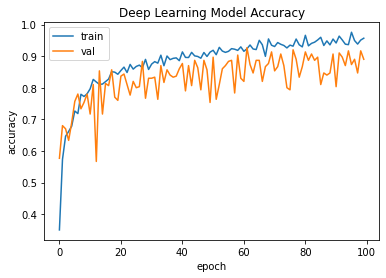

Final Validation Accuracy:  0.8899999856948853


In [66]:
#Experiment 5A: Lots of random filters, Persistence Images Concatenated
random_filters = Filters.random_filters(l=3,n=25)
diagrams = CPT.CPT(X,random_filters)
pers_images = Vectorize.diagrams_to_images(diagrams)
pers_image_con = Vectorize.concatenate_top_features(pers_images)
Testing.test_knn(pers_image_con,y)
Testing.test_boosted_tree(pers_image_con,y)
Testing.test_NN(pers_image_con,y)

kNN Results:  [0.441 0.468 0.439]
Average kNN Result:  0.44933333333333336
Gradient Boosting Results:  [0.555 0.554 0.55 ]
Average Gradient Boosting Result:  0.553


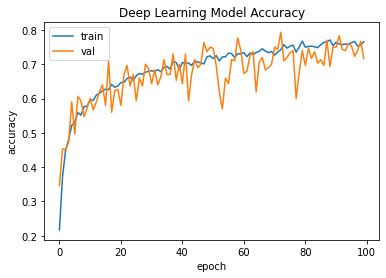

Final Validation Accuracy:  0.7166666388511658


In [67]:
#Experiment 5B: Lots of random filters, Persistence Images Averaged
pers_image_av = Vectorize.average_top_features(pers_images)
Testing.test_knn(pers_image_av,y)
Testing.test_boosted_tree(pers_image_av,y)
Testing.test_NN(pers_image_av,y)

kNN Results:  [0.662 0.683 0.674]
Average kNN Result:  0.673
Gradient Boosting Results:  [0.601 0.652 0.606]
Average Gradient Boosting Result:  0.6196666666666667


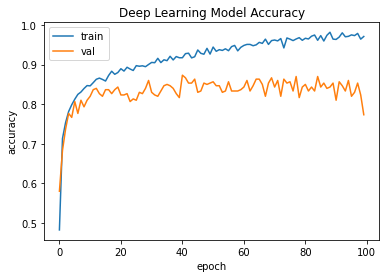

Final Validation Accuracy:  0.7733333110809326


In [68]:
#Experiment 5C: Lots of random filters, Total Persistence Concatenated
tot_pers = Vectorize.diagrams_to_totpers(diagrams)
tot_pers_con = Vectorize.concatenate_top_features(tot_pers)
Testing.test_knn(tot_pers_con,y)
Testing.test_boosted_tree(tot_pers_con,y)
Testing.test_NN(tot_pers_con,y)

kNN Results:  [0.265 0.282 0.274]
Average kNN Result:  0.27366666666666667
Gradient Boosting Results:  [0.289 0.309 0.284]
Average Gradient Boosting Result:  0.294


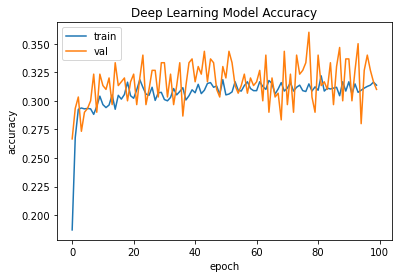

Final Validation Accuracy:  0.3100000023841858


In [69]:
#Experiment 5D: Lots of random filters, Total Persistence Averaged
tot_pers_av = Vectorize.average_top_features(tot_pers)
Testing.test_knn(tot_pers_av,y)
Testing.test_boosted_tree(tot_pers_av,y)
Testing.test_NN(tot_pers_av,y)